In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
from torch.utils.data.dataloader import DataLoader
import torch.utils.data as data_utils
from torch.optim import lr_scheduler
import sparselinear as sl

import numpy as np
import matplotlib.pyplot as plt

from scipy import sparse as sp
from scipy.sparse.linalg import spsolve

import sys,time
import os
import copy
import pickle

In [2]:
import os

directories = ["../__model/ex16_diffusion", "../__result/ex16_diffusion", "../__temp/ex16_diffusion"]

for dir_name in directories:
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

In [3]:
# # Set device
# device = torch.device("cpu")
# print("Using device:", device, '\n')

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device, '\n')

Using device: cuda:0 



In [4]:
# Given parameters
nx = 60
ny = 60
m=nx*ny
tf = 1.0
dt = 2.0e-3
nt = int(tf/dt)
xmin = 0; xmax = 1
ymin = 0; ymax = 1

# set batch_size, number of epochs, paitience for early stop
batch_size = 240
num_epochs = 10000
num_epochs_print = 100
early_stop_patience = 200
num_patience = 50
l_rate = 0.001

# Choose data normalize option (option 1: -1<=X<=1 option 2: 0<=X<=1, option 3: no scaling)
option = 3

# Choose activation function (sigmoid, swish)
activation = 'swish'

# parameters
training_params = np.arange(80,121,5)
print("nt={}".format(nt))
print("training parameters={}".format(training_params))

# train:test split
r_test=0.2

# set the number of nodes in each layer
a = 2
b = int(100)
db = int(10)

M1 = int(a*m) # encoder hidden layer
M2 = b + (m-1)*db # decoder hidden layer

# latent space dimension
f_list=np.array([3,4,5,6])

# generate mesh grid
[xv,yv]=np.meshgrid(np.linspace(xmin,xmax,nx),np.linspace(ymin,ymax,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())
x0_multi_index=(multi_index_j[1:-1,0].flatten(),multi_index_i[1:-1,0].flatten())
x1_multi_index=(multi_index_j[1:-1,-1].flatten(),multi_index_i[1:-1,-1].flatten())
y0_multi_index=(multi_index_j[0,1:-1].flatten(),multi_index_i[0,1:-1].flatten())
y1_multi_index=(multi_index_j[-1,1:-1].flatten(),multi_index_i[-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)
x0_raveled_indicies=np.ravel_multi_index(x0_multi_index,dims)
x1_raveled_indicies=np.ravel_multi_index(x1_multi_index,dims)
x01_raveled_indicies=np.concatenate((x0_raveled_indicies,x1_raveled_indicies))
y0_raveled_indicies=np.ravel_multi_index(y0_multi_index,dims)
y1_raveled_indicies=np.ravel_multi_index(y1_multi_index,dims)
y01_raveled_indicies=np.concatenate((y0_raveled_indicies,y1_raveled_indicies))
fixed_raveled_indicies=np.setdiff1d(full_raveled_indicies,free_raveled_indicies)

# measurements
msmt_idx=full_raveled_indicies

# Gauss-Newton iteration parameters
maxitr=4
tol=1e-8

# random number generator seed
seed=np.random.randint(10)

nt=500
training parameters=[ 80  85  90  95 100 105 110 115 120]


In [5]:
# load snapshot
snapshot = np.array([])
for i in training_params:
    ex = np.load('../__data/ex16_diffusion/ex16_interp_{}.npz'.format(i), allow_pickle = True)
    ex = ex.f.arr_0
    snapshot = np.append(snapshot, ex)
snapshot = snapshot.reshape(len(training_params)*(nt+1),-1).astype('float32')
print(snapshot.shape,snapshot.dtype)

# number of data points
ndata = snapshot.shape[0]

# generate mesh grid
[xv,yv]=np.meshgrid(np.linspace(xmin,xmax,nx),np.linspace(ymin,ymax,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)

orig_data_u=np.copy(snapshot)

# normalize data
if option==1: # option 1: -1<=X<=1
    print("option {}: -1<=X<=1".format(option))
    u_ref = (np.max(orig_data_u,axis=0)+np.min(orig_data_u,axis=0))/2.0
    u_scale = (np.max(orig_data_u,axis=0)-np.min(orig_data_u,axis=0))/2.0
    u_scale = np.where(u_scale > np.finfo('float32').resolution, u_scale, 1)
    u_scale_reciprocal = np.reciprocal(u_scale)  
    data_u = u_scale_reciprocal*(orig_data_u-u_ref)
    
elif option==2: # option 2: 0<=X<=1
    print("option {}: 0<=X<=1".format(option))
    u_ref = np.min(orig_data_u,axis=0)    
    u_scale = np.max(orig_data_u,axis=0)-np.min(orig_data_u,axis=0)    
    u_scale = np.where(u_scale > np.finfo('float32').resolution, u_scale, 1)    
    u_scale_reciprocal = np.reciprocal(u_scale)    
    data_u = u_scale_reciprocal*(orig_data_u-u_ref)
elif option==3: # option 3: no scale applied
    print("option {}: no scaling".format(option))
    u_ref = np.zeros(orig_data_u.shape[1],dtype='float32')
    u_scale = np.ones(orig_data_u.shape[1],dtype='float32')   
    u_scale_reciprocal = u_scale
    data_u = u_scale_reciprocal*(orig_data_u-u_ref)
else:
    raise NameError('{} is given for option, but it must be either 1, 2 or 3'.format(option))

# check shapes of snapshot
print('data shape \t {}'.format(data_u.shape))
print('data dtype \t {}'.format(data_u.dtype))

# restore data
rest_data_u = u_ref + u_scale*data_u

# check precision
print('max. abs difference \t {}'.format(np.max(np.abs(orig_data_u-rest_data_u))))

# define testset and trainset indices
nset = len(training_params)
test_ind = np.array([],dtype='int')
for foo in range(nset):
    np.random.seed(foo)
    rand_perm = np.sort(np.random.permutation(nt+1)[:int(r_test*(nt+1))])
    rand_ind = np.arange(foo*(nt+1),(foo+1)*(nt+1))[rand_perm]
    test_ind = np.append(test_ind,rand_ind)
test_ind.sort()
train_ind = np.setdiff1d(np.arange(ndata),test_ind)

# set trainset and testset
# np.random.seed(0)
np.random.shuffle(train_ind)
np.random.shuffle(test_ind)
trainset = data_u[train_ind]
testset = data_u[test_ind] 

# set dataset
dataset = {'train':data_utils.TensorDataset(torch.tensor(trainset,dtype=torch.float32)),
           'test':data_utils.TensorDataset(torch.tensor(testset,dtype=torch.float32))}

# compute dataset shapes
dataset_shapes = {'train':trainset.shape,'test':testset.shape}
print("train set size: {} \t test set size: {}".format(dataset_shapes['train'],dataset_shapes['test']))

# set data loaders
train_loader = DataLoader(dataset=dataset['train'],batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset=dataset['test'],batch_size=batch_size, shuffle=False, num_workers=0)
data_loaders = {'train':train_loader, 'test':test_loader}

# data size
data_size=np.prod(orig_data_u.shape)
print('Data size:{:.8e}({:.4}GB)'.format(data_size,data_size*4/2**30))

(4509, 3600) float32
option 3: no scaling
data shape 	 (4509, 3600)
data dtype 	 float32
max. abs difference 	 0.0
train set size: (3609, 3600) 	 test set size: (900, 3600)
Data size:1.62324000e+07(0.06047GB)


In [6]:
def create_mask_2d(m,b,db):
    
    # local
    Mb=sp.diags([np.ones(nx),np.ones(nx),np.ones(nx)],[0,-1,1],(nx,nx))
    M=sp.kron(sp.eye(ny),Mb,format="csr")

    Ib=sp.eye(nx)
    N=sp.kron(sp.diags([np.ones(ny),np.ones(ny),np.ones(ny)],[0,-1,1],(ny,ny)),Ib,format="csr")

    local=(M+N).astype('int8')
    I,J,V=sp.find(local)
    local[I,J]=1
    
    # basis
    M2 = int(b + db*(m-1))
    basis = np.zeros((m,M2),dtype='int8')

    block = np.ones(b,dtype='int8')
    ind = np.arange(b)
    for row in range(m):
        col = ind + row*db
        basis[row,col] = block
    
    # mask
    col_ind=np.array([],dtype='int8')
    row_ind=np.array([],dtype='int8')
    for i in range(m):
        col=basis[sp.find(local[i])[1]].sum(axis=0).nonzero()[0]
        row=i*np.ones(col.size).astype(int)

        col_ind=np.append(col_ind,col)
        row_ind=np.append(row_ind,row)

    connection=np.vstack((row_ind,col_ind))

    # data=np.ones(row_ind.size,dtype='int8')
    # mask=sp.csr_matrix((data,(row_ind,col_ind)),shape=(m,M2)).toarray()
    
    print("Sparsity in {} by {} mask: {:.2f}%".format(m, M2, (1.0-connection.shape[1]/(m*M2))*100))
    
#     plt.figure()
#     plt.spy(mask)
#     plt.show()

    return connection

# Train model

Sparsity in 3600 by 36090 mask: 99.12%
./diffusion_model/ex16_AE_3_swish_seed_5.p
./diffusion_temp/ex16_AE_3_swish_temp_seed_5.pkl
./diffusion_temp/ex16_AE_3_swish_checkpoint_seed_5.tar
./diffusion_result/ex16_AE_3_swish_loss_seed_5.png
./diffusion_result/ex16_AE_3_swish_rel_recon_seed_5.png
./diffusion_result/ex16_AE_3_swish_avg_rel_err_seed_5.png
./diffusion_result/ex16_AE_3_swish_max_rel_err_seed_5.png
./diffusion_result/ex16_AE_3_swish_rel_err_seed_5.png
Activation function: swish
Encoder parameters:2.59488000e+07(0.09667GB) Decoder parameters:1.28316000e+06(0.00478GB)

--------checkpoint not restored--------


Start first training... m=3600, f=3, a=2, b=100, db=10

Epoch 1000/10000, Learning rate 0.0001
----------
train MSELoss: 1.3699413009406086e-06
test MSELoss: 1.613516633369727e-06

Epoch 2000/10000, Learning rate 1.0000000000000002e-07
----------
train MSELoss: 5.111923198490925e-07
test MSELoss: 4.838354300318315e-07

Epoch 3000/10000, Learning rate 1.0000000000000002e-07
-

/home/youngkyu/.local/lib/python3.10/site-packages/sparselinear/sparselinear.py:301: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:618.)
  weight = torch.sparse.FloatTensor(self.indices, self.weights, (self.out_features, self.in_features))


./diffusion_model/ex16_AE_4_swish_seed_5.p
./diffusion_temp/ex16_AE_4_swish_temp_seed_5.pkl
./diffusion_temp/ex16_AE_4_swish_checkpoint_seed_5.tar
./diffusion_result/ex16_AE_4_swish_loss_seed_5.png
./diffusion_result/ex16_AE_4_swish_rel_recon_seed_5.png
./diffusion_result/ex16_AE_4_swish_avg_rel_err_seed_5.png
./diffusion_result/ex16_AE_4_swish_max_rel_err_seed_5.png
./diffusion_result/ex16_AE_4_swish_rel_err_seed_5.png
Activation function: swish
Encoder parameters:2.59560000e+07(0.09669GB) Decoder parameters:1.31925000e+06(0.004915GB)

--------checkpoint not restored--------


Start first training... m=3600, f=4, a=2, b=100, db=10

Epoch 1000/10000, Learning rate 1e-05
----------
train MSELoss: 7.063284247422731e-07
test MSELoss: 6.984973007699106e-07

Epoch 2000/10000, Learning rate 1e-05
----------
train MSELoss: 3.9258343106629827e-07
test MSELoss: 3.864497368037216e-07


KeyboardInterrupt: 

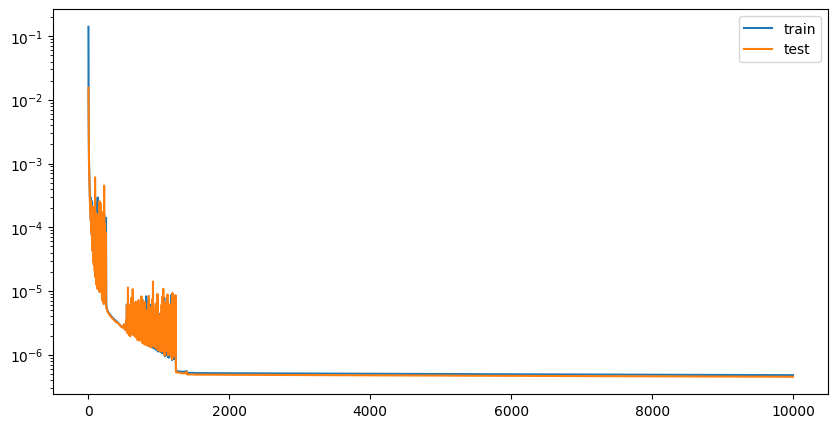

In [7]:
np.random.seed(seed)
torch.manual_seed(seed)

# sparsity and shape of mask
# mask_2d=create_mask_2d(m,b,db)
connection=torch.tensor(create_mask_2d(m,b,db))

for i in range(len(f_list)):
    f = f_list[i] # latent dimension

    # Set file names
    file_name_AE="../__model/ex16_diffusion/ex16_AE_"+str(f)+"_swish_seed_"+str(seed)+".p"
    file_name_AE_temp="../__temp/ex16_diffusion/ex16_AE_"+str(f)+"_swish_temp_seed_"+str(seed)+".pkl"
    PATH = '../__temp/ex16_diffusion/ex16_AE_'+str(f)+"_swish_checkpoint_seed_"+str(seed)+".tar"
    loss_hist_name="../__result/ex16_diffusion/ex16_AE_"+str(f)+"_swish_loss_seed_"+str(seed)+".p"
    loss_fig_name="../__result/ex16_diffusion/ex16_AE_"+str(f)+"_swish_loss_seed_"+str(seed)+".png"
    rel_recon_fig_name="../__result/ex16_diffusion/ex16_AE_"+str(f)+"_swish_rel_recon_seed_"+str(seed)+".png"
    avg_rel_err_fig_name="../__result/ex16_diffusion/ex16_AE_"+str(f)+"_swish_avg_rel_err_seed_"+str(seed)+".png"
    max_rel_err_fig_name="../__result/ex16_diffusion/ex16_AE_"+str(f)+"_swish_max_rel_err_seed_"+str(seed)+".png"
    rel_err_fig_name="../__result/ex16_diffusion/ex16_AE_"+str(f)+"_swish_rel_err_seed_"+str(seed)+".png"

    print(file_name_AE)
    print(file_name_AE_temp)
    print(PATH)
    print(loss_fig_name)
    print(rel_recon_fig_name)
    print(avg_rel_err_fig_name)
    print(max_rel_err_fig_name)
    print(rel_err_fig_name)
    
    if activation=='sigmoid':
        print('Activation function: sigmoid')
        class Encoder(nn.Module):
            def __init__(self,m,M1,f):
                super(Encoder,self).__init__()
                self.full = nn.Sequential(
                    nn.Linear(m,M1),
                    nn.Sigmoid(),
                    nn.Linear(M1,f,bias=False)
                )

            def forward(self, y):     
                y = y.view(-1,m)
                T = self.full(y)
                T = T.squeeze()

                return T

        class Decoder(nn.Module):
            def __init__(self,f,M2,m):
                super(Decoder,self).__init__()
                self.full = nn.Sequential(
                    nn.Linear(f,M2),
                    nn.Sigmoid(),
                    # nn.Linear(M2,m,bias=False)
                    sl.SparseLinear(M2,m,bias=False,connectivity=connection)
                )

            def forward(self,T):
                T = T.view(-1,f)
                y = self.full(T)
                y = y.squeeze()

                return y

    elif activation=='swish':
        print('Activation function: swish')
        def silu(input):
            return input * torch.sigmoid(input)

        class SiLU(nn.Module):
            def __init__(self):
                super().__init__()

            def forward(self, input):
                return silu(input)

        class Encoder(nn.Module):
            def __init__(self,m,M1,f):
                super(Encoder,self).__init__()
                self.full = nn.Sequential(
                    nn.Linear(m,M1),
                    SiLU(),
                    nn.Linear(M1,f,bias=False)
                )

            def forward(self, y):     
                y = y.view(-1,m)
                T = self.full(y)
                T = T.squeeze()

                return T

        class Decoder(nn.Module):
            def __init__(self,f,M2,m):
                super(Decoder,self).__init__()
                self.full = nn.Sequential(
                    nn.Linear(f,M2),
                    SiLU(),
                    # nn.Linear(M2,m,bias=False)
                    sl.SparseLinear(M2,m,bias=False,connectivity=connection)
                )

            def forward(self,T):
                T = T.view(-1,f)
                y = self.full(T)
                y = y.squeeze()

                return y
    else:
        raise NameError('{} is given for option, but it must be either sigmoid or swish'.format(activation))
        
        
    # number of parameters and memory
    en_para=m*M1+M1+M1*f
    # de_para=f*M2+M2+np.count_nonzero(mask_2d)
    de_para=f*M2+M2+connection.shape[1]
    # print('Encoder parameters:{:.8e}({:.4}GB)'.format(en_para,en_para*4/2**30),\
    #       'Decoder parameters:{:.8e}({:.4}GB)'.format(de_para,(f*M2+M2+M2*m)*4/2**30))
    print('Encoder parameters:{:.8e}({:.4}GB)'.format(en_para,en_para*4/2**30),\
          'Decoder parameters:{:.8e}({:.4}GB)'.format(de_para,de_para*4/2**30))
    
    # load model
    try:
        checkpoint = torch.load(PATH, map_location=device)

        encoder = Encoder(m,M1,f).to(device)
        decoder = Decoder(f,M2,m).to(device)

        # # Prune
        # prune.custom_from_mask(decoder.full[2], name='weight', mask=torch.tensor(mask_2d).to(device))    

        optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=l_rate)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,patience=num_patience) 

        loss_func = nn.MSELoss(reduction='mean')

        encoder.load_state_dict(checkpoint['encoder_state_dict'])
        decoder.load_state_dict(checkpoint['decoder_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        last_epoch = checkpoint['epoch']
        loss_hist = checkpoint['loss_hist']
        best_loss = checkpoint['best_loss']
        early_stop_counter = checkpoint['early_stop_counter']
        best_encoder_wts = checkpoint['best_encoder_wts']
        best_decoder_wts = checkpoint['best_decoder_wts']

        print("\n--------checkpoint restored--------\n")

        # resume training
        print("")
        print('Re-start {}th training... m={}, f={},a={}, b={}, db={}'.format(last_epoch+1, m, f, a, b, db))
    except:
        encoder = Encoder(m,M1,f).to(device)
        decoder = Decoder(f,M2,m).to(device)

        # # Prune
        # prune.custom_from_mask(decoder.full[2], name='weight', mask=torch.tensor(mask_2d).to(device))

        optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=l_rate)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,patience=num_patience) 

        loss_func = nn.MSELoss(reduction='mean')

        last_epoch = 0
        loss_hist = {'train':[],'test':[]}
        best_loss = float("inf")
        early_stop_counter = 1
        best_encoder_wts = copy.deepcopy(encoder.state_dict())
        best_decoder_wts = copy.deepcopy(decoder.state_dict())

        print("\n--------checkpoint not restored--------\n")

        # start training
        print("")
        print('Start first training... m={}, f={}, a={}, b={}, db={}'.format(m, f, a, b, db))
    pass

    # train model
    since = time.time()

    for epoch in range(last_epoch+1,num_epochs+1):   

        if epoch%num_epochs_print == 0:
            print()
            print('Epoch {}/{}, Learning rate {}'.format(
                epoch, num_epochs, optimizer.state_dict()['param_groups'][0]['lr']))
            print('-' * 10)

        # Each epoch has a training and test phase
        for phase in ['train', 'test']:
            if phase == 'train':
                encoder.train()  # Set model to training mode
                decoder.train()  # Set model to training mode
            else:
                encoder.eval()   # Set model to evaluation mode
                decoder.eval()   # Set model to evaluation mode

            running_loss = 0.0

            # Iterate over data
            for data, in data_loaders[phase]:
                inputs = data.to(device)
                targets = data.to(device)

                if phase == 'train':
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    outputs = decoder(encoder(inputs))
                    loss = loss_func(outputs, targets)

                    # backward
                    loss.backward()

                    # optimize
                    optimizer.step()  

                    # add running loss
                    running_loss += loss.item()*inputs.shape[0]
                else:
                    with torch.set_grad_enabled(False):
                        outputs = decoder(encoder(inputs))
                        running_loss += loss_func(outputs,targets).item()*inputs.shape[0]

            # compute epoch loss
            epoch_loss = running_loss / dataset_shapes[phase][0]
            loss_hist[phase].append(epoch_loss)

            # update learning rate
            if phase == 'train':
                scheduler.step(epoch_loss)

            if epoch%num_epochs_print == 0:
                print('{} MSELoss: {}'.format(
                    phase, epoch_loss))

        # deep copy the model
        if round(loss_hist['test'][-1],10) < round(best_loss,10):
            best_loss = loss_hist['test'][-1]
            early_stop_counter = 1
            best_encoder_wts = copy.deepcopy(encoder.state_dict())
            best_decoder_wts = copy.deepcopy(decoder.state_dict())
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stop_patience:  
                break

        # save checkpoint every num_epoch_print
        if epoch%num_epochs_print== 0:
            torch.save({
                        'epoch': epoch,
                        'encoder_state_dict': encoder.state_dict(),
                        'decoder_state_dict': decoder.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss_hist': loss_hist,
                        'best_loss': best_loss,
                        'early_stop_counter': early_stop_counter,
                        'best_encoder_wts': best_encoder_wts,
                        'best_decoder_wts': best_decoder_wts,
                        }, PATH)        

    print()
    print('Epoch {}/{}, Learning rate {}'.format(epoch, num_epochs, optimizer.state_dict()['param_groups'][0]['lr']))
    print('-' * 10)
    print('train MSELoss: {}'.format(loss_hist['train'][-1]))
    print('test MSELoss: {}'.format(loss_hist['test'][-1]))

    time_elapsed = time.time() - since

    # load best model weights
    encoder.load_state_dict(best_encoder_wts)
    decoder.load_state_dict(best_decoder_wts)

    # compute best train MSELoss
    encoder.to('cpu').eval()
    decoder.to('cpu').eval()

    with torch.set_grad_enabled(False):
        train_inputs = torch.tensor(data_u[train_ind])
        train_targets = torch.tensor(data_u[train_ind])
        train_outputs = decoder(encoder(train_inputs))
        train_loss = loss_func(train_outputs,train_targets).item()

    # print out training time and best results
    print()
    if epoch < num_epochs:
        print('Early stopping: {}th training complete in {:.0f}h {:.0f}m {:.0f}s'\
              .format(epoch-last_epoch, time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    else:
        print('No early stopping: {}th training complete in {:.0f}h {:.0f}m {:.0f}s'\
              .format(epoch-last_epoch, time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print('-' * 10)
    print('Best train MSELoss: {}'.format(train_loss))
    print('Best test MSELoss: {}'.format(best_loss))

    # save models
    print()
    print("Saving after {}th training to".format(epoch),file_name_AE_temp)
    torch.save((encoder,decoder),file_name_AE_temp)
    
    # delete checkpoint
    try:
        os.remove(PATH)
        print()
        print("checkpoint removed")
    except:
        print("no checkpoint exists") 

    # release gpu memory
    torch.cuda.empty_cache()

    # plot train and test loss
    plt.figure(figsize=(10,5))
    plt.semilogy(loss_hist['train'])
    plt.semilogy(loss_hist['test'])
    plt.legend(['train','test'])
    # plt.show()   
    plt.savefig(loss_fig_name)
    
    # load models
    try:
        encoder_u,decoder_u = torch.load(file_name_AE_temp,map_location='cpu')
        print("\n--------model restored--------\n")
    except:
        print("\n--------model not restored--------\n")
        pass

    # load weights and bias
    en_wu1_s=encoder_u.full[0].weight.detach().numpy().astype('float32')
    en_bu1=encoder_u.full[0].bias.detach().numpy().astype('float32')
    en_wu2=encoder_u.full[2].weight.detach().numpy().astype('float32')
    de_wu1=decoder_u.full[0].weight.detach().numpy().astype('float32')
    de_bu1=decoder_u.full[0].bias.detach().numpy().astype('float32')
    # de_wu2_s=decoder_u.full[2].weight.detach().numpy().astype('float32')
    # de_wu2_s_sp=sp.csr_matrix(de_wu2_s,dtype='float32')
    aaa=decoder.full[2].weight.detach()
    de_wu2_s_sp=sp.csr_matrix((aaa.values(),(aaa.indices()[0],aaa.indices()[1])),
                            shape=aaa.size(),dtype='float32')
    de_wu2_s=de_wu2_s_sp.toarray().astype('float32')

    # rescale weights
    en_wu1=en_wu1_s*u_scale_reciprocal
    de_wu1T=de_wu1.T
    de_wu2T=u_scale*de_wu2_s.T
    de_wu2=de_wu2T.T
    de_wu2_sp=sp.csr_matrix(de_wu2,dtype='float32')
    de_wu2T_sp=de_wu2_sp.T
    
    # save weights and references   
    AE={'en_wu1':en_wu1,'en_bu1':en_bu1,'en_wu2':en_wu2,
        'de_wu1':de_wu1,'de_bu1':de_bu1,'de_wu2':de_wu2,
        'de_wu1T':de_wu1T,'de_wu2T':de_wu2T,'de_wu2_sp':de_wu2_sp,'de_wu2T_sp':de_wu2T_sp,'u_ref':u_ref,}

    with open(file_name_AE,'wb') as ffff:
        pickle.dump(AE,ffff)
        
    # save loss history
    with open(loss_hist_name,'wb') as f5:
        pickle.dump(loss_hist,f5)


checkpoint removed


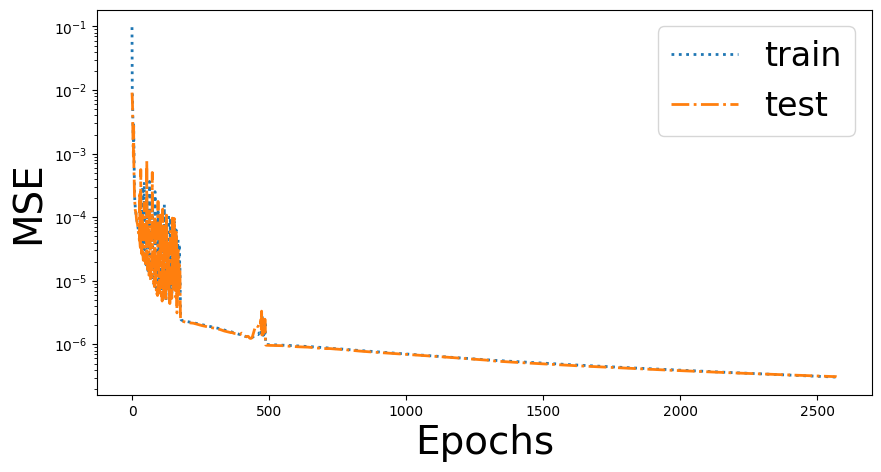

In [8]:
# delete checkpoint
try:
    os.remove(PATH)
    print()
    print("checkpoint removed")
except:
    print("no checkpoint exists") 

# release gpu memory
torch.cuda.empty_cache()

# plot train and test loss
plt.figure(figsize=(10,5))
plt.semilogy(loss_hist['train'],linestyle='dotted',linewidth=2)
plt.semilogy(loss_hist['test'],linestyle='dashdot',linewidth=2)
plt.legend(['train','test'],fontsize=24)
plt.xlabel("Epochs",fontsize=28)
plt.ylabel("MSE",fontsize=28)
# plt.show()   
plt.savefig(loss_fig_name)

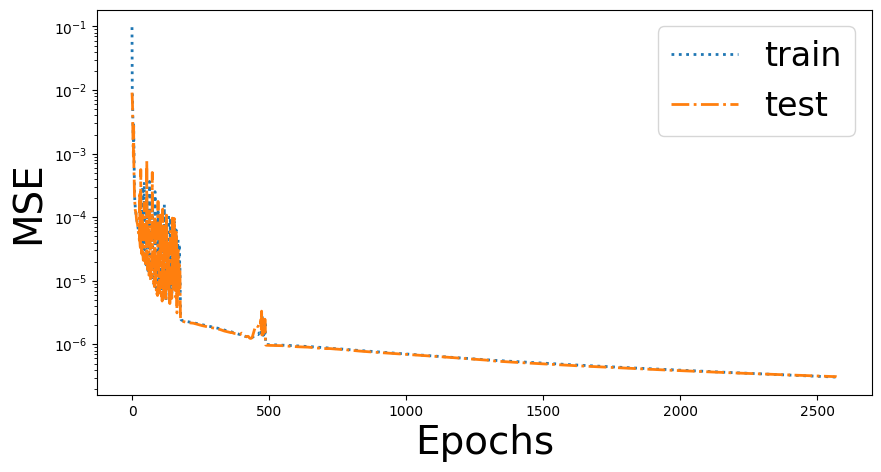

In [11]:
for i in range(len(f_list)):
    f = f_list[i] # latent dimension
    
    loss_hist_name="../__result/ex16_diffusion/ex16_AE_"+str(f)+"_swish_loss_seed_"+str(seed)+".p"
    loss_fig_name="../__result/ex16_diffusion/ex16_AE_"+str(f)+"_swish_loss_seed_"+str(seed)+".png"
    
    with open(loss_hist_name,'rb') as f6:
        loss_hist_name=pickle.load(f6)
    
    plt.figure(figsize=(10,5))
    plt.semilogy(loss_hist['train'],linestyle='dotted',linewidth=2)
    plt.semilogy(loss_hist['test'],linestyle='dashdot',linewidth=2)
    plt.legend(['train','test'],fontsize=24)
    plt.xlabel("Epochs",fontsize=28)
    plt.ylabel("MSE",fontsize=28)
    # plt.show()   
    plt.savefig(loss_fig_name)

# AE MSE loss

In [12]:
# training_params = np.arange(80,121,5)

# load snapshot
snapshot = np.array([])
for i in training_params:
    ex = np.load('../__data/ex16_diffusion/ex16_interp_{}.npz'.format(i), allow_pickle = True)
    ex = ex.f.arr_0
    snapshot = np.append(snapshot, ex)
snapshot = snapshot.reshape(len(training_params)*(nt+1),-1).astype('float32')

# number of data points
ndata = snapshot.shape[0]

orig_data_u=np.copy(snapshot)

# f_list=np.array([3,4,5,6])
print("Latent Sapce Dim.: {}".format(f_list))
for i in range(len(f_list)):
    f = f_list[i] # latent dimension

    # Set file names
    file_name_AE="../__model/ex16_diffusion/ex16_AE_"+str(f)+"_swish_seed_"+str(seed)+".p"
    print(file_name_AE)

    with open(file_name_AE,'rb') as fff:
        AE = pickle.load(fff)

    en_wu1=AE['en_wu1']
    en_bu1=AE['en_bu1']
    en_wu2=AE['en_wu2']
    de_wu1=AE['de_wu1']
    de_bu1=AE['de_bu1']
    de_wu2=AE['de_wu2']
    de_wu1T=AE['de_wu1T']
    de_wu2T=AE['de_wu2T']
    de_wu2_sp=AE['de_wu2_sp']
    de_wu2T_sp=AE['de_wu2T_sp']
    u_ref=AE['u_ref']

    latent_dim=de_wu1.shape[1]

    # numpy version of AE
    def sigmoid_np(input):
        return (1.0/(1.0+np.exp(-input))).astype('float32')

    def encoder_u_np_forward(x):
        z1 = en_wu1.dot(x) + en_bu1
        a1 = z1 * sigmoid_np(z1)
        y = en_wu2.dot(a1)   
        return y

    def decoder_u_np_forward(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = z1 * sigmoid_np(z1)
        y = de_wu2.dot(a1)  
        return y

    def decoder_u_sp_forward(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = z1 * sigmoid_np(z1)
        y = sp.csr_matrix.dot(de_wu2_sp,a1)
        return y

    def decoder_u_np_forward_backwardT(x):
        z1 = de_wu1.dot(x) + de_bu1
        sigma = sigmoid_np(z1)
        a1 = z1 * sigma
        y = de_wu2.dot(a1)

        dout = de_wu1T
        dout = (sigma+a1*(1-sigma))*dout
        dydxT = dout.dot(de_wu2T)   
        return y,dydxT

    def decoder_u_sp_forward_backwardT(x):
        z1 = de_wu1.dot(x) + de_bu1
        sigma = sigmoid_np(z1)
        a1 = z1 * sigma
        y = sp.csr_matrix.dot(de_wu2_sp,a1)

        dout = de_wu1T
        dout = (sigma+a1*(1-sigma))*dout
        dydxT = sp.csr_matrix.dot(dout,de_wu2T_sp)
        return y,dydxT

    # compute MSELoss
    comp_orig_data_u=np.zeros((ndata,f))
    rest_orig_data_u=np.zeros(orig_data_u.shape)

    for k in range(ndata):
        comp_orig_data_u[k]=encoder_u_np_forward(orig_data_u[k]-u_ref)
        rest_orig_data_u[k]=decoder_u_sp_forward(comp_orig_data_u[k]) + u_ref

    print("MSELoss of AE (rescaled): {:.8e}".format(
        np.linalg.norm(orig_data_u-rest_orig_data_u)**2/np.prod(orig_data_u.shape)))

Latent Sapce Dim.: [3 4 5 6]
./diffusion_model/ex16_AE_3_swish_seed_5.p
MSELoss of AE (rescaled): 4.71025214e-07


# Projection Error and Residual Snapshot

In [14]:
f_list=np.array([3,4,5,6]); 
for i in range(len(f_list)):
    f = f_list[i] # latent dimension

    # Set file names
    file_name_AE="../__model/ex16_diffusion/ex16_AE_"+str(f)+"_swish_seed_"+str(seed)+".p"
    file_path_prj_result = "../__result/ex16_diffusion/ex16_AE_"+str(f)+"_swish_proj_result_seed_"+str(seed)+".p"
    file_path_residual="../__result/ex16_diffusion/ex16_AE_"+str(f)+"_swish_residual_seed_"+str(seed)+".p"
    file_path_residual_SVD="../__model/ex16_diffusion/ex16_AE_"+str(f)+"_swish_residual_SVD_seed_"+str(seed)+".p"

    print(file_name_AE)
    print(file_path_prj_result)
    print(file_path_residual)
    print(file_path_residual_SVD)
    
    with open(file_name_AE,'rb') as fff:
        AE = pickle.load(fff)

    en_wu1=AE['en_wu1']
    en_bu1=AE['en_bu1']
    en_wu2=AE['en_wu2']
    de_wu1=AE['de_wu1']
    de_bu1=AE['de_bu1']
    de_wu2=AE['de_wu2']
    de_wu1T=AE['de_wu1T']
    de_wu2T=AE['de_wu2T']
    de_wu2_sp=AE['de_wu2_sp']
    de_wu2T_sp=AE['de_wu2T_sp']
    u_ref=AE['u_ref']

    latent_dim=de_wu1.shape[1]

    # numpy version of AE
    def sigmoid_np(input):
        return (1.0/(1.0+np.exp(-input))).astype('float32')

    def encoder_u_np_forward(x):
        z1 = en_wu1.dot(x) + en_bu1
        a1 = z1 * sigmoid_np(z1)
        y = en_wu2.dot(a1)   
        return y

    def decoder_u_np_forward(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = z1 * sigmoid_np(z1)
        y = de_wu2.dot(a1)  
        return y

    def decoder_u_sp_forward(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = z1 * sigmoid_np(z1)
        y = sp.csr_matrix.dot(de_wu2_sp,a1)
        return y

    def decoder_u_np_forward_backwardT(x):
        z1 = de_wu1.dot(x) + de_bu1
        sigma = sigmoid_np(z1)
        a1 = z1 * sigma
        y = de_wu2.dot(a1)

        dout = de_wu1T
        dout = (sigma+a1*(1-sigma))*dout
        dydxT = dout.dot(de_wu2T)   
        return y,dydxT

    def decoder_u_sp_forward_backwardT(x):
        z1 = de_wu1.dot(x) + de_bu1
        sigma = sigmoid_np(z1)
        a1 = z1 * sigma
        y = sp.csr_matrix.dot(de_wu2_sp,a1)

        dout = de_wu1T
        dout = (sigma+a1*(1-sigma))*dout
        dydxT = sp.csr_matrix.dot(dout,de_wu2T_sp)
        return y,dydxT
    
    results={'avg_rel_err':[],'rel_err':[],'elapsed_time':[]}
    residual_snapshot=[]

    for FOM_parameter in training_params:
        # Load FOM solution
        ex = np.load('../__data/ex16_diffusion/ex16_interp_{}.npz'.format(FOM_parameter), allow_pickle = True)
        ex = ex.f.arr_0
        u_full = ex.reshape(nt+1,-1).astype('float32')

        # take measurments
        um = u_full[:,msmt_idx]

        # Initial condition
        u0=u_full[0]
        u_hat0=encoder_u_np_forward(u0.astype('float32')-u_ref)

        # gappyAE
        t_start_gappyAE=time.time()

        # solution
        u_reduced=np.zeros((nt+1,latent_dim))
        u_gappyAE=np.zeros((nt+1,ny*nx))

        # IC
        u_reduced[0]=np.copy(u_hat0)
        u_gappyAE[0]=np.copy(u0)

        residual=u_full[0]-(u_ref+decoder_u_sp_forward(u_hat0))
        residual_snapshot.append(residual)
        for k in range(nt):
            print("")
            print(k,"th time step:")

            u_hatw=np.copy(u_reduced[k])

            umw,Jg_umT=decoder_u_sp_forward_backwardT(u_hatw)

            umw += u_ref[msmt_idx]

            Jg_um_pinv=np.linalg.pinv(Jg_umT.T)

            r_um_hat = um[k+1]-umw

            res = np.linalg.norm(Jg_umT.dot(r_um_hat))
            res_hist=[res]
            residual=u_full[k+1]-(u_ref+decoder_u_sp_forward(u_hatw))
            residual_snapshot.append(residual)
            for itr in range(maxitr):
                du_hatw = Jg_um_pinv.dot(r_um_hat)

                u_hatw += du_hatw

                umw,Jg_umT=decoder_u_sp_forward_backwardT(u_hatw)

                umw += u_ref[msmt_idx]

                Jg_um_pinv=np.linalg.pinv(Jg_umT.T)

                r_um_hat = um[k+1]-umw

                res = np.linalg.norm(Jg_umT.dot(r_um_hat))
                res_hist.append(res)
                residual=u_full[k+1]-(u_ref+decoder_u_sp_forward(u_hatw))
                residual_snapshot.append(residual)
                print(itr,"th Newton iteration", "res:", "{:.8e}".format(np.linalg.norm(residual)))

                if res<tol:
                    break

            u_reduced[k+1]=u_hatw.copy()
            u_gappyAE[k+1]=u_ref+decoder_u_sp_forward(u_reduced[k+1])

        # elapsed time
        t_elapsed_gappyAE=time.time()-t_start_gappyAE
        print()
        print('Time elapsed: {} sec'.format(t_elapsed_gappyAE))

        # error
        u_rel_err_gappyAE=np.linalg.norm(u_full-u_gappyAE,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
        u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_gappyAE,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100

        print("average relative error of u: {}%".format(u_avg_rel_err))
        print("maximum relative error of u: {}%".format(np.max(u_rel_err_gappyAE)))

        # save result
        results['avg_rel_err'].append(u_avg_rel_err)
        results['rel_err'].append(u_rel_err_gappyAE)
        results['elapsed_time'].append(t_elapsed_gappyAE)

    results['avg_rel_err']=np.array(results['avg_rel_err'])
    results['rel_err']=np.array(results['rel_err'])
    results['elapsed_time']=np.array(results['elapsed_time'])

    with open(file=file_path_prj_result, mode='wb') as ff:
        pickle.dump(results, ff)
        print(file_path_prj_result)

    residual_snapshot=np.array(residual_snapshot)    
    with open(file=file_path_residual, mode='wb') as fff:
        pickle.dump(residual_snapshot, fff)
        print(file_path_residual)

    # do svd decomposition
    U,S,VT=np.linalg.svd(residual_snapshot.T,full_matrices=False)

    SVD={'U':U,'S':S,'VT':VT}
    with open(file=file_path_residual_SVD, mode='wb') as fff:
        pickle.dump(SVD,fff)  
        print(file_path_residual_SVD)         

./diffusion_model/ex16_AE_3_swish_seed_5.p
./diffusion_result/ex16_AE_3_swish_proj_result_seed_5.p
./diffusion_result/ex16_AE_3_swish_residual_seed_5.p
./diffusion_model/ex16_AE_3_swish_residual_SVD_seed_5.p

0 th time step:
0 th Newton iteration res: 2.91694759e-01
1 th Newton iteration res: 2.91694758e-01
2 th Newton iteration res: 2.91694760e-01
3 th Newton iteration res: 2.91694760e-01

1 th time step:
0 th Newton iteration res: 2.54104293e-01
1 th Newton iteration res: 2.54102913e-01
2 th Newton iteration res: 2.54102907e-01
3 th Newton iteration res: 2.54102914e-01

2 th time step:
0 th Newton iteration res: 2.23810322e-01
1 th Newton iteration res: 2.23809262e-01
2 th Newton iteration res: 2.23809267e-01
3 th Newton iteration res: 2.23809270e-01

3 th time step:
0 th Newton iteration res: 1.99568939e-01
1 th Newton iteration res: 1.99568177e-01
2 th Newton iteration res: 1.99568172e-01
3 th Newton iteration res: 1.99568170e-01

4 th time step:
0 th Newton iteration res: 1.794312

# Plot other cases together

In [16]:
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=24)     # fontsize of the axes title
plt.rc('axes', labelsize=24)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsi
plt.rc('figure', titlesize=28)  # fontsize of the figure title

linestyle=['solid','dotted','dashed','dashdot']

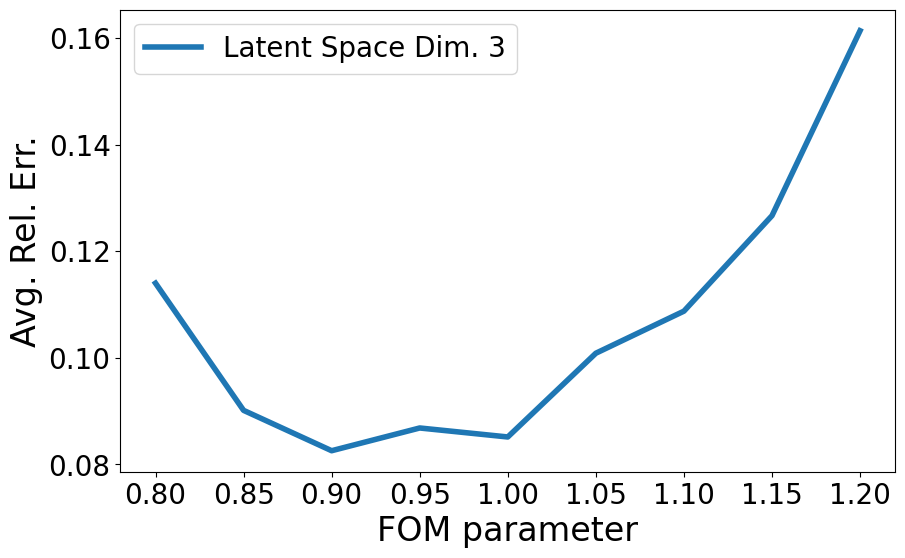

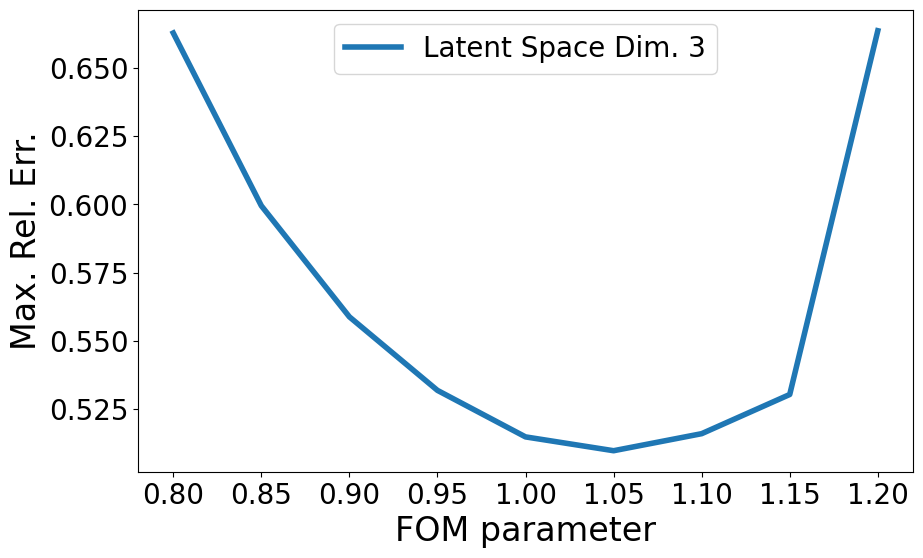

In [17]:
f_list=[3,4,5,6]

plt.figure(num=1,figsize=(10,6))
plt.figure(num=2,figsize=(10,6))
for i in range(len(f_list)):
    f = f_list[i]
    file_path_prj_result = "../__result/ex16_diffusion/ex16_AE_"+str(f)+"_swish_proj_result_seed_"+str(seed)+".p"
    with open(file=file_path_prj_result, mode='rb') as ff:
        results=pickle.load(ff)   
    plt.figure(num=1)
    plt.plot(training_params/100,results['avg_rel_err'],linestyle=linestyle[i],linewidth=4)

    plt.figure(num=2)
    plt.plot(training_params/100,results['rel_err'].max(axis=1),linestyle=linestyle[i],linewidth=4)

plt.figure(num=1)    
plt.xlabel('FOM parameter')
plt.ylabel('Avg. Rel. Err.')
# plt.ylim([0.03418848579768803,0.09671082491576243])
plt.legend(["Latent Space Dim. "+str(f) for f in f_list])
plt.savefig("../__result/ex16_diffusion/ex16_AE_swish_proj_avg_rel_err_seed_"+str(seed)+".png")
# print(plt.gca().get_ylim()); (0.03418848579768803, 0.09073068579684458)

plt.figure(num=2)
plt.xlabel('FOM parameter')
plt.ylabel('Max. Rel. Err.')
# plt.ylim([0.180692401599163,0.6269599283378853])
plt.legend(["Latent Space Dim. "+str(f) for f in f_list])
plt.savefig("../__result/ex16_diffusion/ex16_AE_swish_proj_max_rel_err_seed_"+str(seed)+".png")
# print(plt.gca().get_ylim()); (0.180692401599163, 0.6264354403451524)

In [18]:
print(f_list)
print(training_params)

[3, 4, 5, 6]
[ 80  85  90  95 100 105 110 115 120]


In [ ]:
# i=2; j=-1        
# f=f_list[i]
# param=training_params[j]

# file_path_prj_result = "../__result/ex16_diffusion/ex16_AE_"+str(f)+"_swish_proj_result_seed_"+str(seed)+".p"
# with open(file=file_path_prj_result, mode='rb') as ff:
#     results=pickle.load(ff)

# u_rel_err_gappyAE=results['rel_err'][j,1:]
# plt.figure(figsize=(10,5))

# plt.plot(u_rel_err_gappyAE.flatten())
# plt.xlabel('Data Point')
# plt.ylabel('Relative Error (%)')
# plt.title('Proj. Err. Latent Space Dim.={}, Param = {}'.format(f,param))
# plt.show()

# # plot original data
# vmin=0; vmax=1

# # AE
# plt.figure(figsize=(20,4))

# plt.subplot(1,5,1)
# plt.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_gappyAE[0].reshape(ny,nx),vmin=vmin,vmax=vmax)
# plt.axis('square')
# plt.title('AE @ t=0')

# plt.subplot(1,5,2)
# plt.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_gappyAE[int(nt/4)].reshape(ny,nx),vmin=vmin,vmax=vmax)
# plt.axis('square')
# plt.title('AE @ t={}'.format(dt*int(nt/4)))

# plt.subplot(1,5,3)
# plt.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_gappyAE[int(nt/4)*2].reshape(ny,nx),vmin=vmin,vmax=vmax)
# plt.axis('square')
# plt.title('AE @ t={}'.format(dt*int(nt/4)*2))

# plt.subplot(1,5,4)
# plt.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_gappyAE[int(nt/4)*3].reshape(ny,nx),vmin=vmin,vmax=vmax)
# plt.axis('square')
# plt.title('AE @ t={}'.format(dt*int(nt/4)*3))

# plt.subplot(1,5,5)
# plt.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_gappyAE[nt].reshape(ny,nx),vmin=vmin,vmax=vmax)
# plt.axis('square')
# plt.title('AE @ t={}'.format(dt*nt))

# plt.show()

# # FOM
# plt.figure(figsize=(20,4))

# plt.subplot(1,5,1)
# plt.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_full[0].reshape(ny,nx),vmin=vmin,vmax=vmax)
# plt.axis('square')
# plt.title('FOM @ t=0')

# plt.subplot(1,5,2)
# plt.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_full[int(nt/4)].reshape(ny,nx),vmin=vmin,vmax=vmax)
# plt.axis('square')
# plt.title('FOM @ t={}'.format(dt*int(nt/4)))

# plt.subplot(1,5,3)
# plt.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_full[int(nt/4)*2].reshape(ny,nx),vmin=vmin,vmax=vmax)
# plt.axis('square')
# plt.title('FOM @ t={}'.format(dt*int(nt/4)*2))

# plt.subplot(1,5,4)
# plt.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_full[int(nt/4)*3].reshape(ny,nx),vmin=vmin,vmax=vmax)
# plt.axis('square')
# plt.title('FOM @ t={}'.format(dt*int(nt/4)*3))

# plt.subplot(1,5,5)
# plt.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_full[nt].reshape(ny,nx),vmin=vmin,vmax=vmax)
# plt.axis('square')
# plt.title('FOM @ t={}'.format(dt*nt))

# plt.show()